<a href="https://colab.research.google.com/github/CamK2/ComputerVision/blob/main/Copy_of_CV_GAN_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GAN LAB
In this lab we will create a Generative Adversarial Network for learning the probability model of 28 x 28 pixel MNIST digits.

GANS have been described as the most important 

definitions:

* **zero sum game** - game where for one to win, another must lose. There are no ties or truces.
* **generative model** - probability model of actual data to provide random sampling of data and give the most probable class for a given data point.
* **discriminative model** - separates the input space and given a data point classifies it to the most likely class.
* **neural network** - a network with an input on one end flowing through a network of nodes (having a node function and weights on eah input) and ending in an output.
* **RELU** - Rectified Linear Unit - the output is zero wen the sum of the inputs*weights is < threshold, otherwise the output is equal to the difference of the sum of the inputs*weights-threshold.
* **Leaky RELU** - like a RELU but, when the sum of inputs*weights is less than the threshold, instead of zero it is a line with a small slope. Useful for improving performance in steepest descent training.
* **network weights and thresholds** - the trainable parameters of a neural network.
* **rotational invariance** -doesn't take rotation into account when classifying an image. (a 6 and a 9 will have the same output).
* **translational invariance** - same as rotational but or translations of images.
* **temporal invariance** - doesn't take time into account when classifying an image.
* **convolutional neural network** - 2 functions enter, one function leaves. Ex. using kernals over images.
* **GAN** - Generative Adversarial Network - a probabilistic model comprising a generator network and a discriminator network, trained together to learn a probability model (distribution). 
* **Generator** - a neural network, given random noise generates samples in the input domain.
* **Discriminator** - a convolutional neural network used to classify images.
* **entropy** - a measure of disorder that can be applied to entropy theory as well
* **cross entropy** - a measure of distance between two probability distributions
* **pytorch** - FaceBook's deep learning environment
* **tensorflow** - Google's deep learning environment
* **loss function** - a measure of network error (between predicted and actual data output)
* **steepest descent** - training algorithm in which each successive step changes the parameters in a way which maximizes the reduction in the loss function.
* **training epoch** - one training cycle, number of complete passes over the data

In [ ]:
import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
os.makedirs("images", exist_ok=True)
 
class Opt(object):
    dim = 10
    n_epochs = 100
    batch_size = dim*dim
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    n_cpu = 1
    latent_dim = 100
    img_size = 28
    channels = 1
    sample_interval = 400
opt = Opt()  
 
img_shape = (opt.channels, opt.img_size, opt.img_size)
 
cuda = True if torch.cuda.is_available() else False
 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img
 
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity
 
bce_loss = torch.nn.BCELoss() # BCE - Binary Cross-Entropy
generator = Generator()
discriminator = Discriminator()
 
if cuda: # Programming environment for a GPU
    generator.cuda()
    discriminator.cuda()
    bce_loss.cuda()
 
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)
 
# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
 
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
 
# ----------
#  Training
# ----------
 
saved_imgs = []
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))
        #  train Generator
        generator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        gen_imgs = generator(z)
        # loss measures generator's ability to fool the discriminator:
        # for the generated images, the generator wants the discriminator to think they're real (1)
        # so if the discriminator(gen_imgs) == real == 1, then the generator is doing a good job, there is no loss
        generator_loss = bce_loss(discriminator(gen_imgs), real)
        generator_loss.backward()
        generator_optimizer.step()
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # loss measure discriminator's ability to classify real from generated samples:
        real_loss = bce_loss(discriminator(real_imgs),         real)
        fake_loss = bce_loss(discriminator(gen_imgs.detach()), fake)
        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()
        batches_done = epoch * len(dataloader) + i
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)

Epoch 0 training... done, took 14.8 seconds.
Epoch 1 training... done, took 12.9 seconds.
Epoch 2 training... done, took 14.0 seconds.
Epoch 3 training... done, took 13.8 seconds.
Epoch 4 training... done, took 12.9 seconds.
Epoch 5 training... done, took 13.3 seconds.
Epoch 6 training... done, took 12.9 seconds.
Epoch 7 training... done, took 13.0 seconds.
Epoch 8 training... done, took 12.8 seconds.
Epoch 9 training... done, took 12.7 seconds.
Epoch 10 training... done, took 12.9 seconds.
Epoch 11 training... done, took 12.8 seconds.
Epoch 12 training... done, took 12.8 seconds.
Epoch 13 training... done, took 13.0 seconds.
Epoch 14 training... done, took 13.6 seconds.
Epoch 15 training... done, took 13.2 seconds.
Epoch 16 training... done, took 13.4 seconds.
Epoch 17 training... done, took 13.3 seconds.
Epoch 18 training... done, took 13.2 seconds.
Epoch 19 training... done, took 13.3 seconds.
Epoch 20 training... done, took 13.2 seconds.
Epoch 21 training... done, took 13.2 seconds

IndexError: ignored

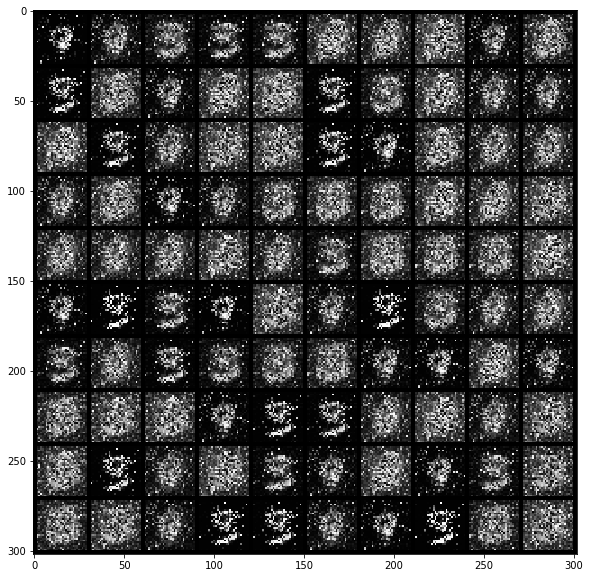

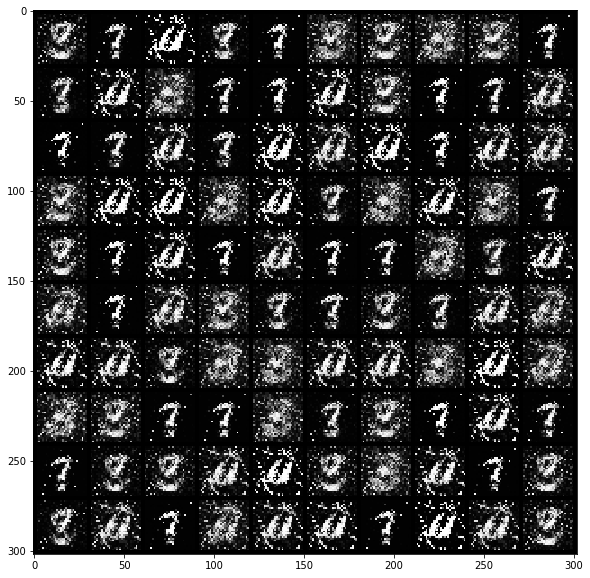

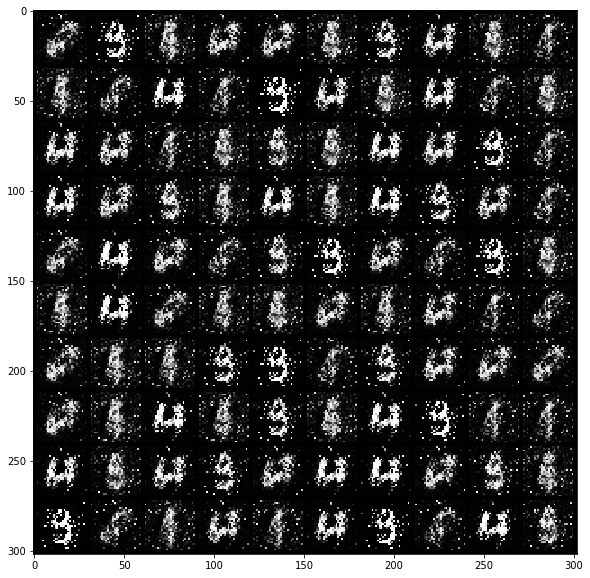

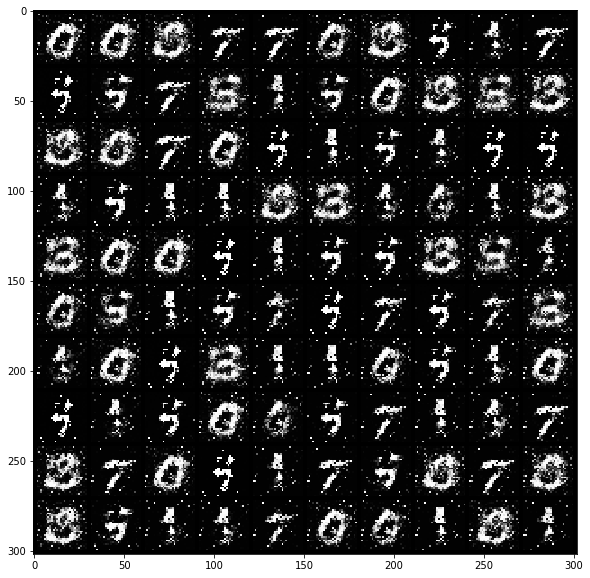

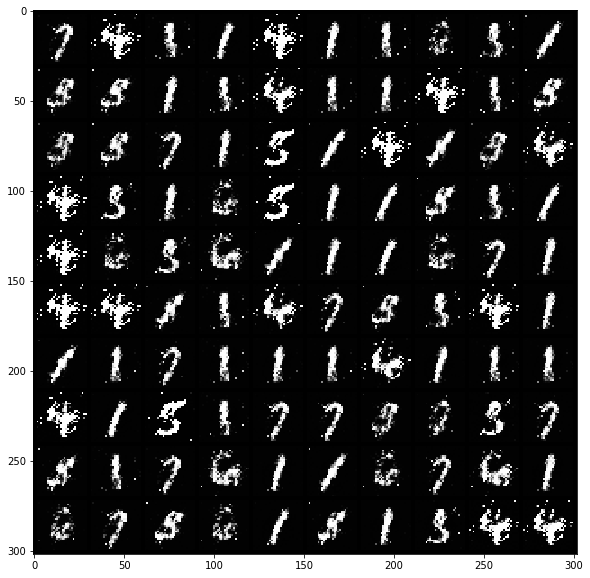

<Figure size 720x720 with 0 Axes>

In [ ]:
img_indexes = [0, 4, 9, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(saved_imgs[i], interpolation='nearest')